In [1]:
if "descended" not in locals():
    descended = 1
    %cd ".."
    
import utils
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from lilith.lilith_utils import *
import warnings
from wotan import flatten
import visualize as vis
import sklearn.metrics
import matplotlib
import torch
from simulations import lightcurve_simulation as lcsim
from astropy.stats import sigma_clip

from dataloading import data_processing as pp
from dataloading import loading as dl

from detection import bls_detection as bls_det
from detection import rnn_detection as rnn_det

/Users/Yke/Desktop/AI/Thesis/ESA/transit-detection-rnn


In [2]:
def read_dvdic(path):
    with open(path, "rb") as f:
        dvdic = pickle.load(f)
    return dvdic

In [3]:
dv_all = read_dvdic("data/lilith/dv/dv_dic.pkl")
dv_sect = {}
for i in [1,2,3,4]:
    dv_sect[i] = read_dvdic(f"data/lilith/sector{i}/dv/dv_dic.pkl")

In [4]:
len(dv_all), len(dv_sect[1]), len(dv_sect[2]), len(dv_sect[3]), len(dv_sect[4])

(1256, 498, 601, 592, 490)

In [5]:
BASE_PATH = "data/lilith"
SECTOR = {i:f"/sector{i}" for i in [1,2,3,4]}  # use as: path = BASE_PATH + SECTOR[i]
[BASE_PATH + "/" + dirname for dirname in os.listdir(BASE_PATH) if os.path.isdir(BASE_PATH + "/" + dirname)]

# load ground-truth and sector sampleids
sampleids_sector = {i:sampleids_from_curl(BASE_PATH+SECTOR[i]+'/fits') for i in SECTOR}
sampleids = set()
for i in SECTOR:
    sampleids.update(sampleids_sector[i])
sampleids = np.array(list(sampleids))

gt_sector = {i:{obj:{} for obj in ["pl", "eb", "beb"]} for i in SECTOR}
gt = {obj:{"params":{}, "sampleids":[]} for obj in ["pl", "eb", "beb"]}
for i in SECTOR:
    gt_path = BASE_PATH+SECTOR[i]+'/ground_truth'
    gt_sector[i]["pl"]["params"], gt_sector[i]["pl"]["sampleids"] = get_pl_data(gt_path, sampleids_sector[i])
    gt_sector[i]["eb"]["params"], gt_sector[i]["eb"]["sampleids"] = get_eb_data(gt_path, sampleids_sector[i], backeb=0)
    gt_sector[i]["beb"]["params"], gt_sector[i]["beb"]["sampleids"] = get_eb_data(gt_path, sampleids_sector[i], backeb=1)
    for obj in ["pl", "eb", "beb"]:
        for sampleid, obj_data in gt_sector[i][obj]["params"].items():  
            if sampleid in gt[obj]["sampleids"]:
                # ground truth already saved from prev sector
                if obj_data != gt[obj]["params"][sampleid]:
                    print("WARNING: inconsistent ground-truth data")
            elif obj_data != {}:
                gt[obj]["params"][sampleid] = obj_data
                gt[obj]["sampleids"].append(sampleid)
for obj in ["pl", "eb", "beb"]:
    gt[obj]["sampleids"] = np.array(gt[obj]["sampleids"])
    for sampleid in sampleids:
        if sampleid not in gt[obj]["sampleids"]:
            gt[obj]["params"][sampleid] = {}

In [6]:
# select test samples and display statistics
test_sampleids = {obj:set() for obj in ["all", "pl", "eb", "beb"]}  # not to be used for training

def inter(a, b):
    return np.intersect1d(a, b)

for i1 in SECTOR:
    for i2 in SECTOR:
        if i2 > i1:
            s_ids = inter(sampleids_sector[i1], sampleids_sector[i2])
            pl_ids = inter(gt_sector[i1]["pl"]["sampleids"], gt_sector[i2]["pl"]["sampleids"])
            eb_ids = inter(gt_sector[i1]["eb"]["sampleids"], gt_sector[i2]["eb"]["sampleids"])
            beb_ids = inter(gt_sector[i1]["beb"]["sampleids"], gt_sector[i2]["beb"]["sampleids"])
            
            test_sampleids["all"].update(s_ids), test_sampleids["pl"].update(pl_ids)
            test_sampleids["eb"].update(eb_ids), test_sampleids["beb"].update(beb_ids)

In [7]:
pl_ids_corrected = []
for s_id in test_sampleids["pl"]:
    if (s_id not in test_sampleids["eb"]) and (s_id not in test_sampleids["beb"]):
        pl_ids_corrected.append(s_id)
pl_ids_corrected= np.array(pl_ids_corrected)

In [8]:
def get_trange(sector):
    with open(f"data/lilith/sector{sector}/raw_batches/test/00000-00249", "rb") as f:
        b = pickle.load(f)
    return (b["time"][0][0], b["time"][0][-1])
sector_range = {i:get_trange(i) for i in [1,2,3,4]}

In [9]:
def consec_sectors(sec_str, only_two=False):
    consec = 0
    for s in sec_str:
        if s=="1":
            consec += 1
        elif consec and s=="0":
            return False
    if only_two:
        if consec != 2:
            return False
    return True

def consec_from_data(times, only_two=False):
    if len(times)==1:
        print("WARNING: test sample with only one sector")
    t_cat = np.concatenate(times)
    if np.max(np.diff(t_cat))>10:
        return False
    if only_two and len(times) > 2: 
        return False
    return True

def retrieve_sector(time):
    midt = np.nanmean(time)
    for s in sector_range:
        if midt > sector_range[s][0] and midt < sector_range[s][1]:
            return s

In [10]:
consec = {}
excluded = []
pbar = tqdm(os.listdir("data/eval/lilith/processed_nn_basic"))
for fname in pbar:
    try:
        with open("data/eval/lilith/processed_nn_basic/"+fname, "rb") as f:
            b = pickle.load(f)
        for s_id, data in b.items():
            if s_id in pl_ids_corrected:
                if len(data["time"])==0:
                    excluded.append(s_id)
                    continue
                consec[s_id] = consec_from_data(data["time"], only_two=1)
    except:
        pbar.close()
        raise

  5%|▌         | 1/20 [00:00<00:18,  1.02it/s]

 70%|███████   | 14/20 [00:11<00:04,  1.25it/s]

100%|██████████| 20/20 [00:17<00:00,  1.16it/s]

In [11]:
for s_id in excluded:
    keep = pl_ids_corrected!=s_id
    pl_ids_corrected = pl_ids_corrected[keep]

In [12]:
def fix_t0(t0, period, sectors, warnings=False):
    sectors = sectors if isinstance(sectors, list) else [sectors]
    tt = t0
    while tt < sector_range[sectors[0]][0]:
        tt += period
    while tt > sector_range[sectors[0]][0]:
        tt -= period
    
    if tt + period > sector_range[sectors[-1]][1] and warnings:
        print(f"WARNING: period too large to fix t0 (p = {round(period,2)} days)")
    return tt + period

def accept_planet(pl_data, sectors):
    sectors = sectors if isinstance(sectors, list) else [sectors]
    tt = fix_t0(pl_data["t0"], pl_data["orb_period"], sectors)
    if pl_data["orb_period"] < 2:
        return False
    n_transits = 0
    while tt < sector_range[sectors[-1]][1]:
        n_transits += 1
        tt += pl_data["orb_period"]
    if n_transits < 3:
        return False
    return True  

In [13]:
targets_sect = {i:{} for i in [1,2,3,4]}
rejected_sect = {i:{} for i in [1,2,3,4]}

for sector in [1,2,3,4]:
    for s_id in pl_ids_corrected:
        if s_id in gt_sector[sector]["pl"]["params"]:
            targets_sect[sector][s_id] = {}
            rejected_sect[sector][s_id] = {}
            for pl_i, pl_data in gt_sector[sector]["pl"]["params"][s_id].items():
                if accept_planet(pl_data, sector):
                    targets_sect[sector][s_id][pl_i] = pl_data
                else:
                    rejected_sect[sector][s_id][pl_i] = pl_data

In [14]:
# load_path = "data/eval/lilith/processed_bls_12h_outlier"
# write_path = "results/bls_multi_3it_outlier_detections"

# fnames = [fnm for fnm in os.listdir(load_path) if not fnm.startswith(".")]
# utils.make_dir(write_path)
# pbar = tqdm(fnames)
# for fname in pbar:
#     try:
#         bls_detections = {i:{} for i in [1,2,3,4,0]}
#         batch = dl.load_data(load_path + "/"+ fname)
#         if batch is None:
#             continue
        
#         for sampleid in batch:
#             if sampleid in pl_ids_corrected:
#                 for i in range(len(batch[sampleid]["time"])):
#                     time = batch[sampleid]["time"][i]
#                     sector = retrieve_sector(time)
#                     flat = batch[sampleid]["flux"][i]
#                     detections = bls_det.algorithm(time, flat, num_iters=3)
#                     bls_detections[sector][sampleid] = detections

# #                 if consec[sampleid]:
# #                     time = np.concatenate(batch[sampleid]["time"])
# #                     flat = np.concatenate(batch[sampleid]["flux"])
# #                     detections = bls_det.algorithm(time, flat, min_transits=5, num_iters=3, freq_fac=6)
# #                     bls_detections[0][sampleid] = detections
#         with open(write_path + "/" +fname, "wb") as f:
#             pickle.dump(bls_detections, f) 
#     except:
#         pbar.close()
#         raise

# # combine bls_detections
# bls_detections_sect = {i:{s_id:{} for s_id in targets_sect[i]} for i in [1,2,3,4]}
# for fnm in os.listdir("results/bls_multi_3it_detections"):
#     with open("results/bls_multi_3it_detections/"+fnm, "rb") as f:
#         b = pickle.load(f)
#     for i in [1,2,3,4]:
#         bls_detections_sect[i] = {**bls_detections_sect[i], **b[i]}
# with open("results/bls_multi_3it_detections.pkl", "wb") as f:
#     pickle.dump(bls_detections_sect, f)

In [15]:
# rnn_detections_sect_alg1 = {i:{s_id:{} for s_id in targets_sect[i]} for i in [1,2,3,4]}
# rnn_detections_sect_alg2_10 = {i:{s_id:{} for s_id in targets_sect[i]} for i in [1,2,3,4]}
# rnn_detections_sect_alg2_25 = {i:{s_id:{} for s_id in targets_sect[i]} for i in [1,2,3,4]}
# rnn_detections_sect_alg2_50 = {i:{s_id:{} for s_id in targets_sect[i]} for i in [1,2,3,4]}
# pbar = tqdm(os.listdir("data/eval/lilith/nn_pts_final"))
# for fnm in pbar:
#     try:
#         if not fnm.startswith("."):
#             with open("data/eval/lilith/nn_basic_pts/"+fnm, "rb") as f:
#                 b_pts = pickle.load(f)
#             with open("data/eval/lilith/processed_nn_basic/"+fnm, "rb") as f:
#                 b = pickle.load(f)
            
#             for s_id in b:
                
#                 for i in range(len(b[s_id]["time"])):
#                     sector = retrieve_sector(b[s_id]["time"][i])
#                     detected1 = rnn_det.algorithm1(b_pts[s_id][i].copy(), num_iters=3, 
#                                                   min_transits=3, p_min=2, p_max=None, step_mult=2, 
#                                                   smooth=True, peak_frac=2, show_steps=False)
#                     detected2,_ = rnn_det.algorithm2(b_pts[s_id][i].copy(), None, num_iters=3, smooth=True, 
#                                                      p_min=2, peak_thresh=0.10, return_steps=True)
#                     detected3,_ = rnn_det.algorithm2(b_pts[s_id][i].copy(), None, num_iters=3, smooth=True,
#                                                      p_min=2, peak_thresh=0.25, return_steps=True)
#                     detected4,_ = rnn_det.algorithm2(b_pts[s_id][i].copy(), None, num_iters=3, smooth=True, 
#                                                      p_min=2, peak_thresh=0.50, return_steps=True)
#                     rnn_detections_sect_alg1[sector][s_id] = detected1
#                     rnn_detections_sect_alg2_10[sector][s_id] = detected2
#                     rnn_detections_sect_alg2_25[sector][s_id] = detected3
#                     rnn_detections_sect_alg2_50[sector][s_id] = detected4
#     except:
#         pbar.close()
#         raise

# with open("results/rnn_multi_det3it_alg1_final.pkl", "wb") as f:
#     pickle.dump(rnn_detections_sect_alg1, f)
# with open("results/rnn_multi_det3it_alg2_10_detections_final.pkl", "wb") as f:
#     pickle.dump(rnn_detections_sect_alg2_10, f)
# with open("results/rnn_multi_det3it_alg2_25_detections_final.pkl", "wb") as f:
#     pickle.dump(rnn_detections_sect_alg2_25, f)
# with open("results/rnn_multi_det3it_alg2_50_detections_final.pkl", "wb") as f:
#     pickle.dump(rnn_detections_sect_alg2_50, f)

In [16]:
# import sys
# del sys.modules["detection.rnn_detection"]
# del sys.modules["detection"]
# from detection import rnn_detection as rnn_det

In [17]:
pipeline_detections_sect = {i:{} for i in [1,2,3,4]}
for sector in [1,2,3,4]:
    for s_id in pl_ids_corrected:
        if s_id in gt_sector[sector]["pl"]["params"]:
            pipeline_detections_sect[sector][s_id] = {}
            if s_id in dv_sect[sector] and dv_sect[sector][s_id]["n_transit"] >= 3 \
            and dv_sect[sector][s_id]["period"] >= 2:
                snr = dv_sect[sector][s_id]["snr"]
                pipeline_detections_sect[sector][s_id][snr] = dv_sect[sector][s_id]

In [18]:
with open("results/bls_multi_3it_detections.pkl", "rb") as f:
    bls_detections_sect = pickle.load(f)
    
    
with open("results/bls_multi_3it_outlier_detections.pkl", "rb") as f:
    bls_out_detections_sect = pickle.load(f)
    
for i in [1,2,3,4]:
    for s_id in bls_detections_sect[i]:
        if s_id not in bls_out_detections_sect[i]:
            bls_out_detections_sect[i][s_id] = {}

In [19]:
with open("results/rnn_multi_det3it_alg1_final.pkl", "rb") as f:
    rnn_detections_sect_alg1 = pickle.load(f)
    
with open("results/rnn_multi_det3it_alg2_10_detections_final.pkl", "rb") as f:
    rnn_detections_sect_alg2_10 = pickle.load(f)
with open("results/rnn_multi_det3it_alg2_25_detections_final.pkl", "rb") as f:
    rnn_detections_sect_alg2_25 = pickle.load(f)
with open("results/rnn_multi_det3it_alg2_50_detections_final.pkl", "rb") as f:
    rnn_detections_sect_alg2_50 = pickle.load(f)

In [20]:
def correct_detection(detection, gt_params, sectors, per_frac=0.01, dur_factor=1, warnings=True):
    
    true_per = gt_params["orb_period"]
    true_t0 = fix_t0(gt_params["t0"], true_per, sectors, warnings=warnings)
    dur = gt_params["duration"]
    
    pred_per = detection["period"]
    pred_t0 = detection["t0"]
    
    if pred_t0 < sector_range[sectors][0]:
        pred_t0+=sector_range[sectors][0]
        
    per_correct = ((1-per_frac)*true_per <= pred_per) and (pred_per <= (1+per_frac)*true_per)
    t0_correct = ((true_t0-0.5*dur_factor*dur) <= pred_t0) and (pred_t0 <= (true_t0+0.5*dur_factor*dur))
    
    return (per_correct and t0_correct), per_correct, t0_correct

def evaluate_thresholds(detections, thresholds, warnings=True, dur_factor=1, per_frac=0.01):
    snames = ["tp", "fp", "fn", "tn"]
    didx = list(detections.keys())[0]
    results = {mname:{sname:[] for sname in snames} for mname in detections[didx]}
    pbar = tqdm(thresholds)
    for thr in pbar:  
        try:
            for mname in detections[didx]:
                tp = fp = tn = fn = 0
                for i in meta:
                    num_planets = len(meta[i])
                    found_planets = 0
                    pl_i_found = []
                    for score, det in detections[i][mname].items():
                        if score >= thr:
                            found_one = False
                            if num_planets > 0:
                                for pl_i in meta[i]:
                                    if pl_i not in pl_i_found:
                                        if correct_detection(det, meta[i][pl_i], int(i.split("-")[0]),
                                                             per_frac=per_frac, dur_factor=dur_factor, 
                                                             warnings=warnings)[0]:
                                            found_one = True
                                            found_planets += 1
                                            pl_i_found.append(pl_i)        
                                            tp += 1
                                            break
                            if not found_one:
                                fp += 1
                    if found_planets > num_planets and warnings:
                        print("WARNING: found more planets than possible")
                    fn += (num_planets-found_planets)
                    # true negative is always inf
                results[mname]["tp"].append(tp), results[mname]["fp"].append(fp) 
                results[mname]["tn"].append(tn), results[mname]["fn"].append(fn) 
        except:
            pbar.close()
            raise
    for mname in detections[didx]:        
        for sname in snames:
            results[mname][sname] = np.array(results[mname][sname])
    return results


def concatenate_sectors(detections, mname=None):
    detections_ = {}
    for sector in detections:
        for s_id in detections[sector]:
            if mname is None:
                detections_[f"{sector}-{s_id}"] = detections[sector][s_id]
            else:
                detections_[f"{sector}-{s_id}"] = {}
                detections_[f"{sector}-{s_id}"][mname] = detections[sector][s_id]
    return detections_

def get_fpr(dic):
    return dic["fp"] / (dic["fp"] + dic["tn"]) 
    
def get_tpr(dic):
    # recall
    return dic["tp"] / (dic["tp"] + dic["fn"])


def get_recall(dic):
    return get_tpr(dic)

def get_precision(dic):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        prec = dic["tp"] / (dic["tp"] + dic["fp"])
    prec[np.isnan(prec)] = 1
    return prec

def get_threshold(threshold_results, thresholds, precision_lvl=0.9, min_recall=0.1):
    precision = get_precision(threshold_results)
    recall = get_recall(threshold_results)
    r_msk = recall > min_recall
    argmin = np.argmin(np.abs(precision[r_msk]-precision_lvl))
    thr = thresholds[argmin]
    return thr, precision[argmin], recall[argmin]

In [21]:
meta = concatenate_sectors(targets_sect)
pipeline_detections = concatenate_sectors(pipeline_detections_sect, "pipeline")
bls_detections = concatenate_sectors(bls_detections_sect, "bls_12h")
bls_out_detections = concatenate_sectors(bls_out_detections_sect, "bls_out_12h")
bls_detections = {i:{**bls_detections[i], **bls_out_detections[i]} for i in bls_detections}

rnn_alg1_detections = concatenate_sectors(rnn_detections_sect_alg1, "rnn_alg1")
rnn_alg2_10_detections = concatenate_sectors(rnn_detections_sect_alg2_10, "rnn_alg2_10")
rnn_alg2_25_detections = concatenate_sectors(rnn_detections_sect_alg2_25, "rnn_alg2_25")
rnn_alg2_50_detections = concatenate_sectors(rnn_detections_sect_alg2_50, "rnn_alg2_50")
rnn_detections = {i:{**rnn_alg1_detections[i], **rnn_alg2_10_detections[i],
                     **rnn_alg2_25_detections[i], **rnn_alg2_50_detections[i]} for i in bls_detections}

In [22]:
rnd = list(meta.keys())[0]
scores = {mname:[] for mname in [*pipeline_detections[rnd], *bls_detections[rnd], *rnn_detections[rnd]]}
for i in meta:
    for mname, dic in {**pipeline_detections[i], **bls_detections[i], **rnn_detections[i]}.items():
        for score in dic:
            scores[mname].append(score)
for mname in scores:
    print(f"{mname}:  min = {round(min(scores[mname]),2)} | max = {round(max(scores[mname]),2)} | " +
          f"avg = {round(np.mean(scores[mname]),2)}")

pipeline:  min = 5.67 | max = 580.11 | avg = 32.83
bls_12h:  min = 2.24 | max = 45.03 | avg = 5.38
bls_out_12h:  min = 2.27 | max = 27.41 | avg = 5.35
rnn_alg1:  min = 0.0 | max = 2.79 | avg = 0.17
rnn_alg2_10:  min = 0.0 | max = 2.8 | avg = 0.56
rnn_alg2_25:  min = 0.01 | max = 2.8 | avg = 1.04
rnn_alg2_50:  min = 0.07 | max = 2.8 | avg = 1.26


In [23]:
pipeline_thresholds =  np.linspace(5,600,100)
pipeline_results = evaluate_thresholds(pipeline_detections, pipeline_thresholds, warnings=1)

100%|██████████| 100/100 [00:00<00:00, 150.01it/s]


In [24]:
bls_thresholds =  np.linspace(0,50,100)
bls_results = evaluate_thresholds(bls_detections, bls_thresholds, warnings=1)

100%|██████████| 100/100 [00:06<00:00, 14.63it/s]


In [25]:
rnn_thresholds = np.linspace(0,3,100)
rnn_results = evaluate_thresholds(rnn_detections, rnn_thresholds, warnings=1, dur_factor=1, per_frac=0.01)

100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


In [26]:
def get_pr_curve(results, mnames, decreasing=True):
    for mname, lbl in mnames.items():
        dic = results[mname]
        rec, prec = get_recall(dic), get_precision(dic)
        rec, prec = rec[::-1], prec[::-1]
        if decreasing:
            for i in range(len(prec)-1):
                prec[i] = max(prec[i], np.max(prec[i+1:]))
        auc = sklearn.metrics.auc(rec, prec)
        lbl = lbl + f"  ({round(auc,2)})"
        plt.plot(rec, prec, label=lbl)
        plt.xlabel("Recall", fontsize=14)
        plt.ylabel("Precision", fontsize=14)
        plt.xticks(fontsize=13), plt.yticks(fontsize=13)

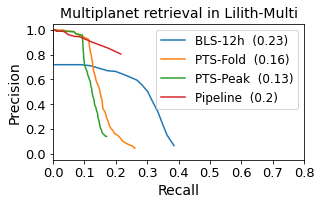

In [27]:
mnames = {#"bls_12h":"BLS-12h",
          "bls_out_12h":"BLS-12h",  # use outliers removed  
          "rnn_alg1":"PTS-Fold",
          "rnn_alg2_10":"PTS-Peak",
          "pipeline":"Pipeline"}
combined_results = {**bls_results, **rnn_results, **pipeline_results}

plt.figure(figsize=(4.5,2.5))
get_pr_curve(combined_results, mnames)
plt.title("Multiplanet retrieval in Lilith-Multi", fontsize=14)
plt.legend(fontsize=12, loc="upper right"), plt.xlim(0.00,0.8), plt.ylim(-0.05,1.05)
plt.savefig("figures/multi_pr.pdf", bbox_inches="tight")
plt.show()

In [28]:
pl_smlpls = np.array([len(meta[i]) for i in meta])
print("lcs: ", len(meta))
print("0 pl:", sum(pl_smlpls==0))
print("1 pl:", sum(pl_smlpls==1))
print("2 pl:", sum(pl_smlpls==2))
print("3 pl:", sum(pl_smlpls==3))
print("4 pl:", sum(pl_smlpls==4))
print("5 pl:", sum(pl_smlpls==5))

print()
print("#planets: ", sum([i*sum(pl_smlpls==i) for i in range(1,10)]))
print("#pl lcs:  ", sum(pl_smlpls>0))

lcs:  6511
0 pl: 3841
1 pl: 2130
2 pl: 474
3 pl: 57
4 pl: 9
5 pl: 0

#planets:  3285
#pl lcs:   2670


In [29]:
def wilson(bool_array, conf=0.95):
    # https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
    n = bool_array.size
    z = 1.96 
    if conf != 0.95:
        print("WARNING: using conf=0.95")  
    phat = bool_array.mean()
    mean = 1/(1+z**2/n) * (phat + z**2/(2*n))
    unc = z/(1+z**2/n) * np.sqrt(phat*(1-phat)/n + z**2/(4*n**2))
    return mean, unc

def get_bin_indc(array, n_bins=10, rng=(-1e9,1e9)):
    stepsize = (min(array.max(),rng[1])-max(array.min(),rng[0])+1e-9)/n_bins
    bin_indc = []
    minimum = max(array.min(),rng[0])
    steps = [minimum+stepsize/2+i*stepsize for i in range(n_bins)]
    for bi in range(n_bins):
        low = minimum + bi*stepsize
        high = minimum + (bi+1)*stepsize
        bin_indc.append( np.where((array>=low)*(array<high))[0] )
    return bin_indc, np.array(steps)

def vs_plot(steps, stats, n_samples, xlbl="", legend=False, labels=None, offset=0.1, fill=True, rot=0, 
            min_acc=0.5, max_acc=1.02, legend_loc="upper left", bbox=(.11,1), newfig=True):
    if newfig:
        plt.figure(figsize=(5,3),facecolor="w")
    offs = 0
    for i,stat in enumerate(stats):
        if fill:
            p = plt.plot(steps, stat["mean"], label=labels[i])
            plt.fill_between(steps, np.array(stat["mean"])-np.array(stat["unc"]), 
                             np.array(stat["mean"])+np.array(stat["unc"]), alpha=.3, color=p[0].get_color())
        else:
            plt.errorbar(steps+offs, stat["mean"], yerr=stat["unc"], capsize=2, label=labels[i])
        if offset:
            offs += offset*(steps[1]-steps[0])
    if rot:
        plt.xticks(fontsize=13, rotation=rot, ha='right')
    else:
        plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel("Fraction correct", fontsize=14)
    plt.xlabel(xlbl, fontsize=14)
    plt.xlim(steps[0]-0.5*(steps[1]-steps[0]),steps[-1]+0.5*(steps[1]-steps[0]))
    plt.ylim(min_acc,max_acc)
#     if legend:
#         plt.legend(loc=legend_loc, framealpha=1, fontsize=12, facecolor="w", ncol=1, bbox_to_anchor=bbox)
    ax = plt.twinx()
    plt.bar(steps, n_samples, alpha=0.2, color="gray", width=(steps[1]-steps[0]), label="samples" if legend else None, zorder=0)
    plt.ylabel("#samples", fontsize=14)
    plt.yticks(fontsize=13)
    if legend:
        plt.legend(loc="lower right", framealpha=0.8, fontsize=12)
    
def plot_1d(model_correct, array, labels, n_bins=10, xlbl="", legend=True, offset=0.01, 
            fill=True, show=True, rot=0, min_acc=0.5, rng=(None,None), max_acc=1.02,
               legend_loc="upper left", bbox=(.11,1), newfig=True):
    
    rng = (-1e9, rng[1]) if rng[0] is None else rng
    rng = (rng[0], 1e9) if rng[1] is None else rng
    
    bin_indc, steps = get_bin_indc(array, n_bins=n_bins, rng=rng)
    n_samples = np.array([len(indc) for indc in bin_indc])
    
    model_confs = {model:{"mean":[],"unc":[]} for model in labels}
    for indc in bin_indc:
        if len(indc)==0:
            for model in model_confs:
                model_confs[model]["mean"].append(np.nan)
                model_confs[model]["unc"].append(np.nan)
        else:
            for i, model in enumerate(model_confs):
                mean, unc = wilson(model_correct[i][indc])
                model_confs[model]["mean"].append(mean)
                model_confs[model]["unc"].append(unc)
    vs_plot(steps, list(model_confs.values()), n_samples, xlbl, legend, labels, offset=offset, 
            fill=fill, rot=rot, min_acc=min_acc, max_acc=max_acc, legend_loc=legend_loc, bbox=bbox, newfig=newfig)
    if show:
        plt.show()

In [30]:
def get_scores(mname, detect_dic, results_dic, thresholds, 
               precision_lvl=0.9, min_recall=0.1, return_sampleids=False):
    thresh = get_threshold(results_dic[mname], thresholds, precision_lvl=precision_lvl, min_recall=0.1)[0]
    correct_detections = [] 
    sampleids = []
    for i in meta:
        for pl_i in meta[i]:
            sampleids.append(f"{i}-{pl_i}")
            correct = False
            for score, det in detect_dic[i][mname].items():
                if score > thresh and correct_detection(det, meta[i][pl_i], int(i.split("-")[0]),
                                                        per_frac=0.01, dur_factor=1, warnings=0)[0]:
                    correct=True
                    break
            correct_detections.append(correct)
    if return_sampleids:
        return np.array(correct_detections), np.array(sampleids)
    return np.array(correct_detections)

def get_num_pl_correct(num, scores, scores_sampleids, meta):
    meta_pl_i = [list(meta[i].keys()) for i in meta]
    meta_i = [i for i in meta]
    
    scores_meta = {i:[] for i in meta}
    for i, s_id_pl in enumerate(scores_sampleids):
        s_id  = "-".join(s_id_pl.split("-")[:-1])
#         pl_i = s_id_pl.split("-")[-1]
        scores_meta[s_id].append(scores[i])
    results = []
    for i in scores_meta:
        if len(scores_meta[i])==num:
            results.append(sum(scores_meta[i]))
    return np.array(results)

def get_data_params(meta, pname, fn=lambda a:a):
    lst = []
    for i in meta:
        for pl_i in meta[i]:
            try:
                lst.append(fn(meta[i][pl_i][pname]))
            except:
                lst.append(-1e9)
    return np.array(lst)

In [31]:
pbar = tqdm(os.listdir("data/eval/lilith/processed_nn_basic"))
for fname in pbar:
    try:
        with open("data/eval/lilith/processed_nn_basic/"+fname, "rb") as f:
            b = pickle.load(f)
        for s_id in b:
            for si, sigma in enumerate(b[s_id]["sigma"]):
                sector = retrieve_sector(b[s_id]["time"][si])
                sec_id = f"{sector}-{s_id}"
                if sec_id in meta:
                    for pl_i in meta[sec_id]:
                        meta[sec_id][pl_i]["sigma"] = sigma
    except:
        pbar.close()
        raise
        
ror = get_data_params(meta, "ror")
sigma = get_data_params(meta, "sigma")
depth = get_data_params(meta, "depth")
t0 = get_data_params(meta, "t0")
duration = get_data_params(meta, "duration", lambda a:a*24)
a = get_data_params(meta, "a")
period = get_data_params(meta, "orb_period")

100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


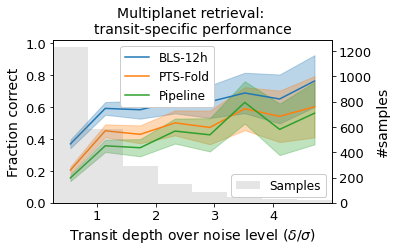

Total lcs: 6511
pl:      3285

PTS-Fold:  857 (0.26)  |  prec: 0.04,  rec: 0.26,  threshold: 0.0
BLS-12h:   1267 (0.39)  |  prec: 0.06,  rec: 0.39,  threshold: 0.0
Pipeline:  710 (0.22)  |  prec: 0.81,  rec: 0.22,  threshold: 5.0


In [78]:
# at threshold for for which recall>0.1 and precision closest to 0.9
prec_lvl = 0.0 # precision_lvl
min_rec = 0.1 # min_recall

rnn_scores, scores_sampleids = get_scores("rnn_alg1", rnn_detections, rnn_results, rnn_thresholds, 
                                         precision_lvl=prec_lvl, min_recall=min_rec, return_sampleids=1)
bls_scores = get_scores("bls_out_12h", bls_detections, bls_results, bls_thresholds,
                       precision_lvl=prec_lvl, min_recall=min_rec)
pipeline_scores = get_scores("pipeline", pipeline_detections, pipeline_results, pipeline_thresholds,
                            precision_lvl=prec_lvl, min_recall=min_rec)

# at threshold for for which recall>0.1 and precision closest to 0.9
rnn_thresh, rnn_prec, rnn_rec = get_threshold(rnn_results["rnn_alg1"], rnn_thresholds,
                                              precision_lvl=prec_lvl, min_recall=min_rec)
bls_thresh, bls_prec, bls_rec = get_threshold(bls_results["bls_out_12h"], bls_thresholds,
                                             precision_lvl=prec_lvl, min_recall=min_rec)
ppl_thresh, ppl_prec, ppl_rec = get_threshold(pipeline_results["pipeline"], pipeline_thresholds,
                                              precision_lvl=prec_lvl, min_recall=min_rec)
plot_1d([bls_scores, rnn_scores, pipeline_scores],
         depth/sigma, labels=["BLS-12h","PTS-Fold", "Pipeline"],
         xlbl="Transit depth over noise level ($\delta$/$\sigma$)", 
         legend=True, n_bins=8, offset=0.1, fill=True, min_acc=0, rng=(0.25009033272340825, 4.999913410707176), show=False,
       legend_loc="center right", bbox=(0.6,0.775))
plt.title("Multiplanet retrieval: \ntransit-specific performance", fontsize=14)
plt.savefig("figures/multi_transits_max_rec.pdf", bbox_inches="tight")
plt.show()

print(f"Total lcs: {len(rnn_detections)}")
print(f"pl:      {len(rnn_scores)}\n")
print(f"PTS-Fold:  {sum(rnn_scores)} ({round(rnn_scores.mean(),2)})  "+
      f"|  prec: {round(rnn_prec, 2)},  rec: {round(rnn_rec,2)},  threshold: {round(rnn_thresh,2)}") 
print(f"BLS-12h:   {sum(bls_scores)} ({round(bls_scores.mean(),2)})  "+
      f"|  prec: {round(bls_prec, 2)},  rec: {round(bls_rec,2)},  threshold: {round(bls_thresh,2)}")
print(f"Pipeline:  {sum(pipeline_scores)} ({round(pipeline_scores.mean(),2)})  "+
      f"|  prec: {round(ppl_prec, 2)},  rec: {round(ppl_rec,2)},  threshold: {round(ppl_thresh,2)}")

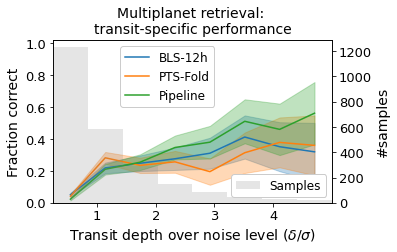

Total lcs: 6511
pl:      3285

PTS-Fold:  374 (0.11)  |  prec: 0.92,  rec: 0.11,  threshold: 1.15
BLS-12h:   396 (0.12)  |  prec: 0.71,  rec: 0.12,  threshold: 11.11
Pipeline:  401 (0.12)  |  prec: 0.91,  rec: 0.12,  threshold: 17.02


In [79]:
# at threshold for for which recall>0.1 and precision closest to 0.9
prec_lvl = 0.9 # precision_lvl
min_rec = 0.1 # min_recall

rnn_scores, scores_sampleids = get_scores("rnn_alg1", rnn_detections, rnn_results, rnn_thresholds, 
                                         precision_lvl=prec_lvl, min_recall=min_rec, return_sampleids=1)
bls_scores = get_scores("bls_out_12h", bls_detections, bls_results, bls_thresholds,
                       precision_lvl=prec_lvl, min_recall=min_rec)
pipeline_scores = get_scores("pipeline", pipeline_detections, pipeline_results, pipeline_thresholds,
                            precision_lvl=prec_lvl, min_recall=min_rec)

# at threshold for for which recall>0.1 and precision closest to 0.9
rnn_thresh, rnn_prec, rnn_rec = get_threshold(rnn_results["rnn_alg1"], rnn_thresholds,
                                              precision_lvl=prec_lvl, min_recall=min_rec)
bls_thresh, bls_prec, bls_rec = get_threshold(bls_results["bls_out_12h"], bls_thresholds,
                                             precision_lvl=prec_lvl, min_recall=min_rec)
ppl_thresh, ppl_prec, ppl_rec = get_threshold(pipeline_results["pipeline"], pipeline_thresholds,
                                              precision_lvl=prec_lvl, min_recall=min_rec)
plot_1d([bls_scores, rnn_scores, pipeline_scores],
         depth/sigma, labels=["BLS-12h","PTS-Fold", "Pipeline"],
         xlbl="Transit depth over noise level ($\delta$/$\sigma$)", 
         legend=True, n_bins=8, offset=0.1, fill=True, min_acc=0, rng=(0.25009033272340825, 4.999913410707176), show=False,
       legend_loc="center right", bbox=(0.6,0.775))
plt.title("Multiplanet retrieval: \ntransit-specific performance", fontsize=14)
plt.savefig("figures/multi_transits_at_prec.pdf", bbox_inches="tight")
plt.show()

print(f"Total lcs: {len(rnn_detections)}")
print(f"pl:      {len(rnn_scores)}\n")
print(f"PTS-Fold:  {sum(rnn_scores)} ({round(rnn_scores.mean(),2)})  "+
      f"|  prec: {round(rnn_prec, 2)},  rec: {round(rnn_rec,2)},  threshold: {round(rnn_thresh,2)}") 
print(f"BLS-12h:   {sum(bls_scores)} ({round(bls_scores.mean(),2)})  "+
      f"|  prec: {round(bls_prec, 2)},  rec: {round(bls_rec,2)},  threshold: {round(bls_thresh,2)}")
print(f"Pipeline:  {sum(pipeline_scores)} ({round(pipeline_scores.mean(),2)})  "+
      f"|  prec: {round(ppl_prec, 2)},  rec: {round(ppl_rec,2)},  threshold: {round(ppl_thresh,2)}")

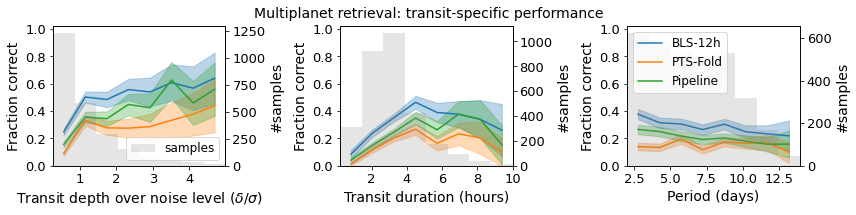

Total lcs: 6511
pl:      3285

PTS-Fold:  493 (0.15)  |  prec: 0.5,  rec: 0.15,  threshold: 0.7
BLS-12h:   993 (0.3)  |  prec: 0.5,  rec: 0.3,  threshold: 7.07
Pipeline:  710 (0.22)  |  prec: 0.81,  rec: 0.22,  threshold: 5.0


In [100]:
# at threshold for for which recall>0.1 and precision closest to 0.9
prec_lvl = 0.5 # precision_lvl
min_rec = 0.1 # min_recall

rnn_scores, scores_sampleids = get_scores("rnn_alg1", rnn_detections, rnn_results, rnn_thresholds, 
                                         precision_lvl=prec_lvl, min_recall=min_rec, return_sampleids=1)
bls_scores = get_scores("bls_out_12h", bls_detections, bls_results, bls_thresholds,
                       precision_lvl=prec_lvl, min_recall=min_rec)
pipeline_scores = get_scores("pipeline", pipeline_detections, pipeline_results, pipeline_thresholds,
                            precision_lvl=prec_lvl, min_recall=min_rec)

# at threshold for for which recall>0.1 and precision closest to 0.9
rnn_thresh, rnn_prec, rnn_rec = get_threshold(rnn_results["rnn_alg1"], rnn_thresholds,
                                              precision_lvl=prec_lvl, min_recall=min_rec)
bls_thresh, bls_prec, bls_rec = get_threshold(bls_results["bls_out_12h"], bls_thresholds,
                                             precision_lvl=prec_lvl, min_recall=min_rec)
ppl_thresh, ppl_prec, ppl_rec = get_threshold(pipeline_results["pipeline"], pipeline_thresholds,
                                              precision_lvl=prec_lvl, min_recall=min_rec)

fig = plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.title(" ", fontsize=8)
plot_1d([bls_scores, rnn_scores, pipeline_scores],
         depth/sigma, labels=["BLS-12h","PTS-Fold", "Pipeline"],
         xlbl="Transit depth over noise level ($\delta$/$\sigma$)", 
         legend=True, n_bins=8, offset=0.1, fill=True, min_acc=0, rng=(0.25009033272340825, 4.999913410707176), show=False,
       legend_loc="center right", bbox=(0.6,0.775), newfig=False)
plt.subplot(1,3,2)
plt.title(" ", fontsize=8)
plot_1d([bls_scores, rnn_scores, pipeline_scores],
         duration, labels=["BLS-12h","PTS-Fold", "Pipeline"],
         xlbl="Transit duration (hours)", 
         legend=False, n_bins=8, offset=0.1, fill=True, min_acc=0, rng=(None, 10), show=False,
       legend_loc="center right", bbox=(0.6,0.775), newfig=False)
plt.subplot(1,3,3)
plt.title(" ", fontsize=8)
plot_1d([bls_scores, rnn_scores, pipeline_scores],
         period, labels=["BLS-12h","PTS-Fold", "Pipeline"],
         xlbl="Period (days)", 
         legend=False, n_bins=8, offset=0.1, fill=True, min_acc=0, rng=(None, None), show=False,
       legend_loc="center right", bbox=(0.6,0.775), newfig=False)

plt.plot([], label="BLS-12h")
plt.plot([], label="PTS-Fold")
plt.plot([], label="Pipeline")
plt.legend(fontsize=12, framealpha=0.8, loc="upper left")
plt.tight_layout()
fig.suptitle("Multiplanet retrieval: transit-specific performance", fontsize=14)
plt.savefig("figures/multi_transit_specific.pdf", bbox_inches="tight")
plt.show()

print(f"Total lcs: {len(rnn_detections)}")
print(f"pl:      {len(rnn_scores)}\n")
print(f"PTS-Fold:  {sum(rnn_scores)} ({round(rnn_scores.mean(),2)})  "+
      f"|  prec: {round(rnn_prec, 2)},  rec: {round(rnn_rec,2)},  threshold: {round(rnn_thresh,2)}") 
print(f"BLS-12h:   {sum(bls_scores)} ({round(bls_scores.mean(),2)})  "+
      f"|  prec: {round(bls_prec, 2)},  rec: {round(bls_rec,2)},  threshold: {round(bls_thresh,2)}")
print(f"Pipeline:  {sum(pipeline_scores)} ({round(pipeline_scores.mean(),2)})  "+
      f"|  prec: {round(ppl_prec, 2)},  rec: {round(ppl_rec,2)},  threshold: {round(ppl_thresh,2)}")

In [105]:
prec_lvl = 0.5 # precision_lvl
min_rec = 0.1 # min_recall

rnn_scores, scores_sampleids = get_scores("rnn_alg1", rnn_detections, rnn_results, rnn_thresholds, 
                                         precision_lvl=prec_lvl, min_recall=min_rec, return_sampleids=1)
rnn_scores2 = get_scores("rnn_alg2_10", rnn_detections, rnn_results, rnn_thresholds, 
                                         precision_lvl=prec_lvl, min_recall=min_rec)
bls_scores = get_scores("bls_out_12h", bls_detections, bls_results, bls_thresholds,
                       precision_lvl=prec_lvl, min_recall=min_rec)
pipeline_scores = get_scores("pipeline", pipeline_detections, pipeline_results, pipeline_thresholds,
                            precision_lvl=prec_lvl, min_recall=min_rec)


num_correct = {m:{} for m in ["rnn", "peak", "bls", "ppl"]}
for m, mscores in zip(["rnn", "peak", "bls", "ppl"], [rnn_scores, rnn_scores2, 
                                                     bls_scores, pipeline_scores]):
    for pl_num in [0,1,2,3,4]:
        num_correct[m][pl_num] = get_num_pl_correct(pl_num, mscores, scores_sampleids, meta)
        
for pl_num in [0,1,2,3,4]:
    print(f"{pl_num} pl: {len(num_correct['bls'][pl_num])}")
    for m in num_correct:
        string = "  " + m.upper() + " - "
        for pl_correct in range(1, pl_num+1):
            string += f"  {pl_correct}: {sum(num_correct[m][pl_num]==pl_correct)},"
        print(string[:-1])

0 pl: 3841
  RNN -
  PEAK -
  BLS -
  PPL -
1 pl: 2130
  RNN -   1: 371
  PEAK -   1: 314
  BLS -   1: 666
  PPL -   1: 517
2 pl: 474
  RNN -   1: 80,  2: 9
  PEAK -   1: 71,  2: 4
  BLS -   1: 120,  2: 65
  PPL -   1: 152,  2: 1
3 pl: 57
  RNN -   1: 13,  2: 5,  3: 0
  PEAK -   1: 11,  2: 2,  3: 0
  BLS -   1: 8,  2: 20,  3: 6
  PPL -   1: 32,  2: 0,  3: 0
4 pl: 9
  RNN -   1: 1,  2: 0,  3: 0,  4: 0
  PEAK -   1: 0,  2: 0,  3: 0,  4: 0
  BLS -   1: 4,  2: 2,  3: 1,  4: 0
  PPL -   1: 7,  2: 0,  3: 0,  4: 0


In [82]:
# lcs:  6511
# 0 pl: 3841
# 1 pl: 2130
# 2 pl: 474
# 3 pl: 57
# 4 pl: 9

In [1]:
6511 - 3841

2670

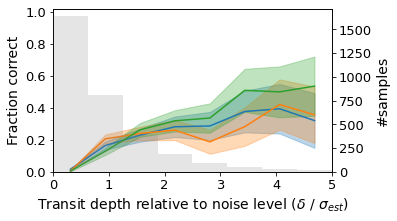

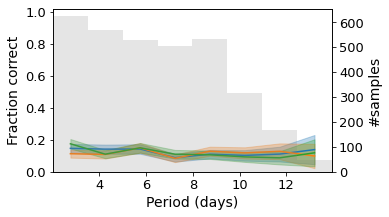

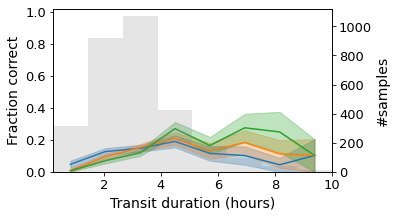

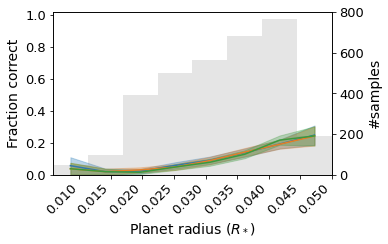

In [83]:
# a,b=duration,gran_period
# a,b=depth*1000,gran_sigma
# plot_1d([bls_scores, rnn_scores, pipeline_scores],
#         1 - np.vstack((a,b)).min(0)/np.vstack((a,b)).max(0), labels=["BLS-12h","PTS-Fold","Pipeline"], xlbl="x", 
#          legend=False, n_bins=4, offset=0.1, fill=True, min_acc=0, rng=(None,0.5), max_acc=None)

plot_1d([bls_scores, rnn_scores, pipeline_scores],
         depth/sigma, labels=["BLS-12h","PTS-Fold","Pipeline"], 
        xlbl="Transit depth relative to noise level ($\delta$ / $\sigma_{est}$)", 
         legend=False, n_bins=8, offset=0.1, fill=True, min_acc=0, rng=(None,5))

plot_1d([bls_scores, rnn_scores, pipeline_scores],
         period, labels=["BLS-12h","PTS-Fold","Pipeline"], xlbl="Period (days)", 
         legend=False, n_bins=8, offset=0.1, fill=True, min_acc=0, rng=(None,None))

plot_1d([bls_scores, rnn_scores, pipeline_scores],
         duration, labels=["BLS-12h","PTS-Fold","Pipeline"], xlbl="Transit duration (hours)", 
         legend=False, n_bins=8, offset=0.1, fill=True, min_acc=0, rng=(None,10))

plot_1d([bls_scores, rnn_scores, pipeline_scores],
         ror, labels=["BLS-12h","PTS-Fold","Pipeline"], xlbl="Planet radius ($R_*$)", 
         legend=False, n_bins=8, offset=0.1, fill=True, min_acc=0, rng=(None,0.05), rot=45)

# plot_1d([bls_scores, rnn_scores, pipeline_scores],
#          rot_period, labels=["BLS-12h","PTS-Fold","Pipeline"], xlbl="Stellar rotation period (days)", 
#          legend=False, n_bins=8, offset=0.1, fill=True, min_acc=0, show=0, rng=(None,None))

# plot_1d([bls_scores, rnn_scores, pipeline_scores],
#          gran_sigma, labels=["BLS-12h","PTS-Fold","Pipeline"], xlbl="Stellar granulation amplitude (ppt)", 
#          legend=False, n_bins=8, offset=0.1, fill=True, min_acc=0, rng=(None,0.003*1000))

# plot_1d([bls_scores, rnn_scores, pipeline_scores],
#          gran_period, labels=["BLS-12h","PTS-Fold","Pipeline"], xlbl="Stellar granulation period (hours)", 
#          legend=False, n_bins=8, offset=0.1, fill=True, min_acc=0, show=0, rng=(None,40))

In [32]:
def plot_2d(model_correct, array_1, array_2, n_bins_1=10, n_bins_2=10, label_1="", label_2="", min_size=5, 
            show=True, title="", rng1=(-1e9,1e9), rng2=(-1e9,1e9)):
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "orange","yellow","limegreen","green"])
    acc_match = np.linspace(0,1,1000)
    colors = cmap(acc_match)

    bin_indc1, steps1 = get_bin_indc(array_1, n_bins=n_bins_1, rng=rng1)
    bin_indc2, steps2 = get_bin_indc(array_2, n_bins=n_bins_2, rng=rng2)
    stepsize1, stepsize2 = steps1[1]-steps1[0], steps2[1]-steps2[0]

    for i, step1 in enumerate(steps1):
        for j, step2 in enumerate(steps2):
            min1, max1 = step1-0.5*stepsize1, step1+0.5*stepsize1
            min2, max2 = step2-0.5*stepsize2, step2+0.5*stepsize2
            indc = np.array(list(set(bin_indc1[i]).intersection(bin_indc2[j])))
            if len(indc)<min_size:
                color = "white"
            else:
                bin_acc = (model_correct[indc].mean()-0.2)/0.5
                color = colors[np.abs(acc_match-bin_acc).argmin()]
            plt.fill_between([min1, max1], min2, max2, color=color)

    plt.title(title, fontsize=14)
    plt.xlim(steps1[0]-0.5*stepsize1,steps1[-1]+0.5*stepsize1)
    plt.ylim(steps2[0]-0.5*stepsize2,steps2[-1]+0.5*stepsize2)
    cm = plt.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap))
#     cm.ax.set_yticklabels(["$\leq$\n0.5\n","0.6","0.7","0.8","0.9","1.0"])
    cm.ax.set_yticklabels(["$\leq$\n0.2\n","0.3","0.4","0.5","0.6","0.7\n$\geq$"])
    cm.ax.tick_params(labelsize=13)
    plt.xlabel(label_1, fontsize=14)
    plt.ylabel(label_2, fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    cm.set_label("Fraction correct", fontsize=14)
    if show:
        plt.show()
        
def pair_2d(stats, array_1, array_2, titles, label_1, label_2, n_bins_1=10, n_bins_2=10, 
            rng1=(None,None), rng2=(None,None)):
    rng1 = (-1e9, rng1[1]) if rng1[0] is None else rng1
    rng1 = (rng1[0], 1e9) if rng1[1] is None else rng1
    rng2 = (-1e9, rng2[1]) if rng2[0] is None else rng2
    rng2 = (rng2[0], 1e9) if rng2[1] is None else rng2 
        
    plt.figure(figsize=(9,3))
    plt.subplot(1,2,1)
    plot_2d(stats[0], array_1, array_2, title=titles[0],
        label_1=label_1, label_2=label_2, n_bins_1=n_bins_1, n_bins_2=n_bins_2, min_size=5, show=0,
           rng1=rng1, rng2=rng2)
    plt.subplot(1,2,2)
    plot_2d(stats[1], array_1, array_2, title=titles[1],
        label_1=label_1, label_2=label_2, n_bins_1=n_bins_1, n_bins_2=n_bins_2, min_size=5, show=0,
           rng1=rng1, rng2=rng2)
    plt.tight_layout()
    plt.show()

/Users/Yke/Desktop/AI/Thesis/ESA/transit-detection-rnn/venv/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


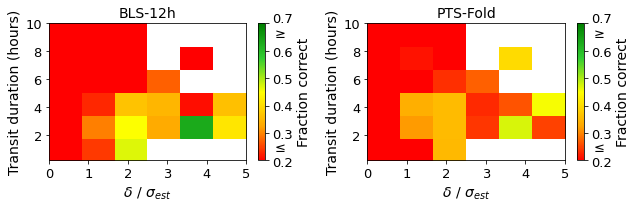

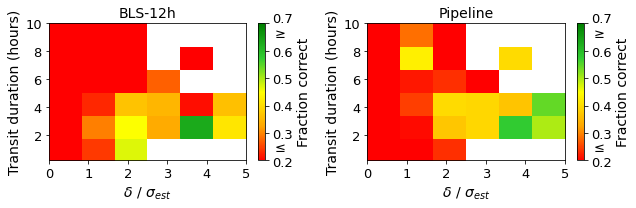

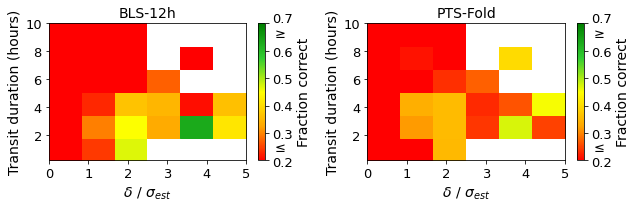

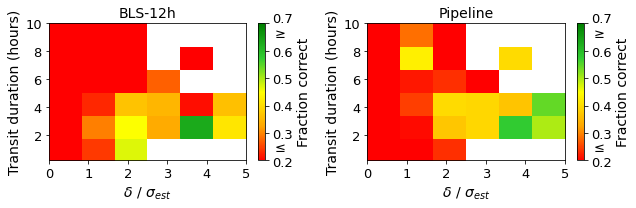

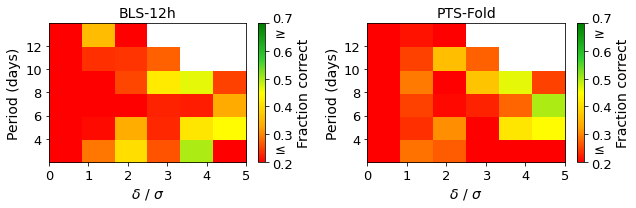

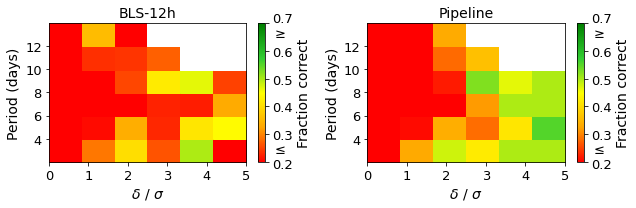

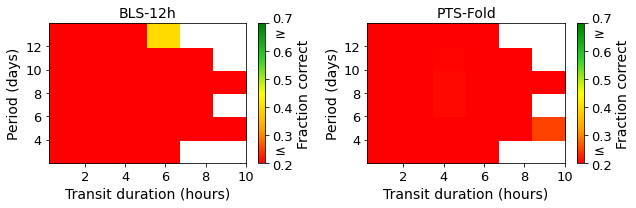

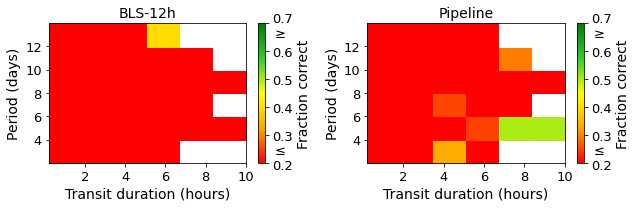

In [86]:
array_1, label_1 = depth/sigma, "$\delta$ / $\sigma_{est}$"
array_2, label_2 = duration, "Transit duration (hours)"
pair_2d([bls_scores, rnn_scores], array_1, array_2, ["BLS-12h", "PTS-Fold"], 
        label_1, label_2, n_bins_1=6, n_bins_2=6, rng1=(None,5), rng2=(None,10))
pair_2d([bls_scores, pipeline_scores], array_1, array_2, ["BLS-12h", "Pipeline"], 
        label_1, label_2, n_bins_1=6, n_bins_2=6, rng1=(None,5), rng2=(None,10))
print("\n\n")
array_1, label_1 = depth/sigma, "$\delta$ / $\sigma_{est}$"
array_2, label_2 = duration, "Transit duration (hours)"
pair_2d([bls_scores, rnn_scores], array_1, array_2, ["BLS-12h", "PTS-Fold"], 
        label_1, label_2, n_bins_1=6, n_bins_2=6, rng1=(None,5), rng2=(None,10))
pair_2d([bls_scores, pipeline_scores], array_1, array_2, ["BLS-12h", "Pipeline"], 
        label_1, label_2, n_bins_1=6, n_bins_2=6, rng1=(None,5), rng2=(None,10))
print("\n\n")
array_1, label_1 = depth/sigma, "$\delta$ / $\sigma$"
array_2, label_2 = period, "Period (days)"
pair_2d([bls_scores, rnn_scores], array_1, array_2, ["BLS-12h", "PTS-Fold"], 
        label_1, label_2, n_bins_1=6, n_bins_2=6, rng1=(None,5), rng2=(None,None))
array_1, label_1 = depth/sigma, "$\delta$ / $\sigma$"
array_2, label_2 = period, "Period (days)"
pair_2d([bls_scores, pipeline_scores], array_1, array_2, ["BLS-12h", "Pipeline"], 
        label_1, label_2, n_bins_1=6, n_bins_2=6, rng1=(None,5), rng2=(None,None))

array_1, label_1 = duration, "Transit duration (hours)"
array_2, label_2 = period, "Period (days)"
pair_2d([bls_scores, rnn_scores], array_1, array_2, ["BLS-12h", "PTS-Fold"], 
        label_1, label_2, n_bins_1=6, n_bins_2=6, rng1=(None,10), rng2=(None,None))
pair_2d([bls_scores, pipeline_scores], array_1, array_2, ["BLS-12h", "Pipeline"], 
        label_1, label_2, n_bins_1=6, n_bins_2=6, rng1=(None,10), rng2=(None,None))

In [33]:
#TESS Science Data Products Description Document (EXP-TESS-ARC-ICD-0014)
#https://archive.stsci.edu/missions/tess/doc/EXP-TESS-ARC-ICD-TM-0014.pdf
# code from lightkurve.TessQualityFlags
AttitudeTweak, SafeMode = 1, 2
CoarsePoint, EarthPoint = 4, 8
Argabrightening, Desat = 16, 32
ApertureCosmic, ManualExclude = 64, 128 
Discontinuity, ImpulsiveOutlier = 256, 512
CollateralCosmic = 1024
#: The first stray light flag is set manually by MIT based on visual inspection.
#: The second stray light flag is set automatically by Ames/SPOC based on background level thresholds.
Straylight, Straylight2 = 2048, 4096

#: DEFAULT bitmask identifies all cadences which are definitely useless.
DEFAULT_BITMASK = (AttitudeTweak | SafeMode | CoarsePoint | EarthPoint |
                   Desat | ManualExclude)

def get_lc(sec_sampleid, meta, datapath="data/eval/lilith/id_batches", clip_outliers=True):
    sector, sampleid, pl_i = [int(e) for e in sec_sampleid.split("-")]
    for fnm in os.listdir(datapath):
        if not fnm.startswith("."):
            from_, to_ = [int(nm) for nm in fnm.split("-")]
            if sampleid >= from_ and sampleid <= to_:
                id_data = {}
                with open(datapath + "/" + fnm, "rb") as f:
                    data = pickle.load(f)[sampleid]
                for i, t in enumerate(data["time"]):
                    if retrieve_sector(t)==sector:
                        id_data["time"] = t
                        id_data["flux"] = data["flux"][i]
                        id_data["mcol"] = data["mom_col"][i]
                        id_data["mrow"] = data["mom_row"][i]
                
                        masks = []
                        for pli in [pl_i]+[j for j in meta[sec_sampleid[:-2]] if j != pl_i]:
                            msk = np.zeros_like(t).astype(bool)
                            period = meta[sec_sampleid[:-2]][pli]["orb_period"]
                            dur = meta[sec_sampleid[:-2]][pli]["duration"]
                            tt = fix_t0(meta[sec_sampleid[:-2]][pli]["t0"], period, sector, warnings=True)
                            while tt < np.nanmax(t):
                                msk[ (t>=(tt-0.5*dur)) & (t<=(tt+0.5*dur))] = True
                                tt += period
                            masks.append(msk) 
                        id_data["masks"] = masks
                        id_data["meta"] = meta[sec_sampleid[:-2]]
                        q_msk = (data["quality"][i] & DEFAULT_BITMASK) > 0
                        zero_msk = id_data["flux"]<=0
                        id_data["time"][q_msk | zero_msk] = np.nan
                        nans = np.isnan(id_data["time"])
                        id_data["flux"][nans] = np.nan
                        id_data["mcol"][nans] = np.nan
                        id_data["mrow"][nans] = np.nan
                        flux_median = np.nanmedian(id_data["flux"])
                        id_data["flux"] /= flux_median
                        id_data["mcol"] /= flux_median
                        id_data["mrow"] /= flux_median
                        flat = flatten(id_data["time"], id_data["flux"], method="median", window_length=utils.min2day(30))
                        
                        if clip_outliers:
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore")
                                clip = sigma_clip(flat, sigma_lower=12, sigma_upper=6).mask
                            id_data["time"][clip], id_data["flux"][clip] = np.nan, np.nan
                        return id_data
            
def A_vs_B(Ascores, Bscores, sampleids):
    results = {}
    results["AandB"] = sampleids[ (Ascores & Bscores) ]
    results["AnotB"] = sampleids[ (Ascores & (~Bscores)) ]
    results["BnotA"] = sampleids[ ((~Ascores) & Bscores) ]
    results["notBnotA"]= results["notAnotB"] = sampleids[ ~(Ascores | Bscores) ]
    return results

In [120]:
prec_lvl = 0.5 # precision_lvl
min_rec = 0.1 # min_recall

rnn_scores, scores_sampleids = get_scores("rnn_alg1", rnn_detections, rnn_results, rnn_thresholds, 
                                         precision_lvl=prec_lvl, min_recall=min_rec, return_sampleids=1)
bls_scores = get_scores("bls_out_12h", bls_detections, bls_results, bls_thresholds,
                       precision_lvl=prec_lvl, min_recall=min_rec)
pipeline_scores = get_scores("pipeline", pipeline_detections, pipeline_results, pipeline_thresholds,
                            precision_lvl=prec_lvl, min_recall=min_rec)

Arnn_Bbls = A_vs_B(rnn_scores, bls_scores, scores_sampleids)
Abls_Bppl = A_vs_B(bls_scores, pipeline_scores,  scores_sampleids)
Arnn_Bppl = A_vs_B(rnn_scores, pipeline_scores, scores_sampleids)

# A = PTS-Fold,  B = BLS,  C = Pipeline
print("A - AandB - AandC - AnotA - AnotB - AnotC")
Atot = np.sum(rnn_scores)
print(np.sum(rnn_scores), f"({round(np.sum(rnn_scores)/Atot,2)}; {round(np.sum(rnn_scores)/len(scores_sampleids),2)})") # A
print(len(Arnn_Bbls["AandB"]), f'({round(len(Arnn_Bbls["AandB"])/Atot,2)}; {round(len(Arnn_Bbls["AandB"])/len(scores_sampleids),2)})') # AandB
print(len(Arnn_Bppl["AandB"]), f'({round(len(Arnn_Bppl["AandB"])/Atot,2)}; {round(len(Arnn_Bppl["AandB"])/len(scores_sampleids),2)})') # AandC
print(0, f'({round(0/len(scores_sampleids),2)}; 0.0)') # AnotA
print(len(Arnn_Bbls["AnotB"]), f'({round(len(Arnn_Bbls["AnotB"])/Atot,2)}; {round(len(Arnn_Bbls["AnotB"])/len(scores_sampleids),2)})') # AnotB
print(len(Arnn_Bppl["AnotB"]), f'({round(len(Arnn_Bppl["AnotB"])/Atot,2)}; {round(len(Arnn_Bppl["AnotB"])/len(scores_sampleids),2)})') # AnotC

print("\nB - BandC - BnotA - BnotB - BnotC")
Btot = np.sum(bls_scores)
print(np.sum(bls_scores), f"({round(np.sum(bls_scores)/Btot,2)}; {round(np.sum(bls_scores)/len(scores_sampleids),2)})") # B
print(len(Abls_Bppl["AandB"]), f'({round(len(Abls_Bppl["AandB"])/Btot,2)}; {round(len(Abls_Bppl["AandB"])/len(scores_sampleids),2)})') # BandC
print(len(Arnn_Bbls["BnotA"]), f'({round(len(Arnn_Bbls["BnotA"])/Btot,2)}; {round(len(Arnn_Bbls["BnotA"])/len(scores_sampleids),2)})') # BnotA
print(0, f'({round(0/len(scores_sampleids),2)}; 0.0)') # BnotB
print(len(Abls_Bppl["AnotB"]), f'({round(len(Abls_Bppl["AnotB"])/Btot,2)}; {round(len(Abls_Bppl["AnotB"])/len(scores_sampleids),2)})') # BnotC

print("\nC - CnotA - CnotB - CnotC")
Ctot = np.sum(pipeline_scores)
print(np.sum(pipeline_scores), f"({round(np.sum(pipeline_scores)/Ctot,2)}; {round(np.sum(pipeline_scores)/len(scores_sampleids),2)})") # C
print(len(Arnn_Bppl["BnotA"]), f'({round(len(Arnn_Bppl["BnotA"])/Ctot,2)}; {round(len(Arnn_Bppl["BnotA"])/len(scores_sampleids),2)})') # CnotA
print(len(Abls_Bppl["BnotA"]), f'({round(len(Abls_Bppl["BnotA"])/Ctot,2)}; {round(len(Abls_Bppl["BnotA"])/len(scores_sampleids),2)})') # CnotB
print(0, f'({round(0/2500,2)}; 0.0)') # CnotC

A - AandB - AandC - AnotA - AnotB - AnotC
493 (1.0; 0.15)
471 (0.96; 0.14)
406 (0.82; 0.12)
0 (0.0; 0.0)
22 (0.04; 0.01)
87 (0.18; 0.03)

B - BandC - BnotA - BnotB - BnotC
993 (1.0; 0.3)
664 (0.67; 0.2)
522 (0.53; 0.16)
0 (0.0; 0.0)
329 (0.33; 0.1)

C - CnotA - CnotB - CnotC
710 (1.0; 0.22)
304 (0.43; 0.09)
46 (0.06; 0.01)
0 (0.0; 0.0)


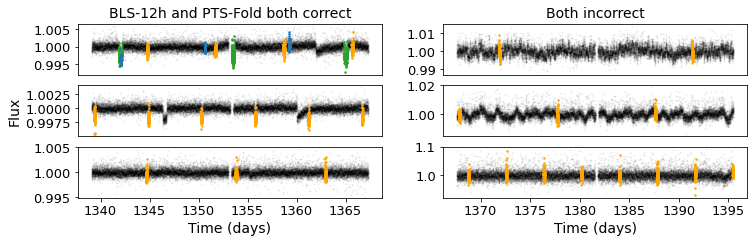

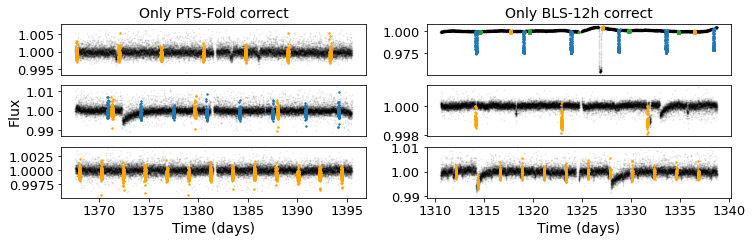

In [210]:
n = 3 
np.random.seed(2)
cs = [plt.plot([])[0].get_color() for i in range(5)]
cs = ["orange"] + [cs[0]] + cs[2:]
plt.close()


fns = {"upper left": lambda i: i*2+1,
       "lower left": lambda i: i*2+1+n*2, 
       "upper right": lambda i: i*2+2, 
       "lower right": lambda i: i*2+2+n*2}
snames = ["AandB", "notAnotB", "AnotB", "BnotA"]
titles = ["BLS-12h and PTS-Fold both correct",
          "Both incorrect", "Only PTS-Fold correct",
          "Only BLS-12h correct"]
locs = ["upper left", "upper right", "lower left", "lower right"]

for fg in [(0,2),(2,4)]:
    plt.figure(figsize=(12,1.1*n*2))
    for si, (sname, loc) in enumerate(zip(snames[fg[0]:fg[1]], locs[fg[0]:fg[1]])):   
        s_ids = np.random.choice(Arnn_Bbls[sname], replace=False, size=n)
        for i, s_id in enumerate(s_ids):
            plt.subplot(n*2, 2, fns[loc](i))
            plt.title(titles[fg[0]:fg[1]][si], fontsize=14) if i == 0 else None
            b = get_lc(s_id, meta)
            plt.ylabel("Flux", fontsize=14) if i==1 and si==0 else None
            
            masks = b["masks"]
            m = np.any(masks, 0)
            vis.plot(b["time"][~m], b["flux"][~m], a=0.05)
            
            for mi, msk in enumerate(masks):
                vis.plot(b["time"][msk], b["flux"][msk], c=cs[mi], s=2, z=200-mi)
            plt.yticks(fontsize=13)
            plt.xticks([]) if i!=n-1 else plt.xticks(fontsize=13)
            plt.xlabel("Time (days)", fontsize=14)  if i==n-1 else None

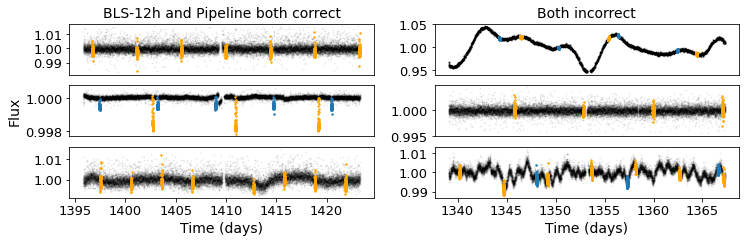

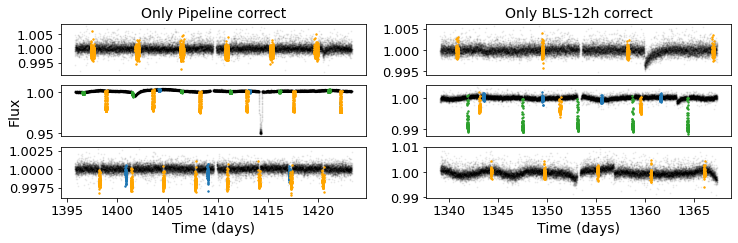

In [196]:
n = 3 
np.random.seed(3)
cs = [plt.plot([])[0].get_color() for i in range(5)]
cs = ["orange"] + [cs[0]] + cs[2:]
plt.close()


fns = {"upper left": lambda i: i*2+1,
       "lower left": lambda i: i*2+1+n*2, 
       "upper right": lambda i: i*2+2, 
       "lower right": lambda i: i*2+2+n*2}
snames = ["AandB", "notAnotB", "AnotB", "BnotA"]
titles = ["BLS-12h and Pipeline both correct",
          "Both incorrect", "Only Pipeline correct",
          "Only BLS-12h correct"]
locs = ["upper left", "upper right", "lower left", "lower right"]

for fg in [(0,2),(2,4)]:
    plt.figure(figsize=(12,1.1*n*2))
    for si, (sname, loc) in enumerate(zip(snames[fg[0]:fg[1]], locs[fg[0]:fg[1]])):   
        s_ids = np.random.choice(Appl_Bbls[sname], replace=False, size=n)
        for i, s_id in enumerate(s_ids):
            plt.subplot(n*2, 2, fns[loc](i))
            plt.title(titles[fg[0]:fg[1]][si], fontsize=14) if i == 0 else None
            b = get_lc(s_id, meta)
            plt.ylabel("Flux", fontsize=14) if i==1 and si==0 else None
            
            masks = b["masks"]
            m = np.any(masks, 0)
            vis.plot(b["time"][~m], b["flux"][~m], a=0.05)
            
            for mi, msk in enumerate(masks):
                vis.plot(b["time"][msk], b["flux"][msk], c=cs[mi], s=2, z=200-mi)
            plt.yticks(fontsize=13)
            plt.xticks([]) if i!=n-1 else plt.xticks(fontsize=13)
            plt.xlabel("Time (days)", fontsize=14)  if i==n-1 else None

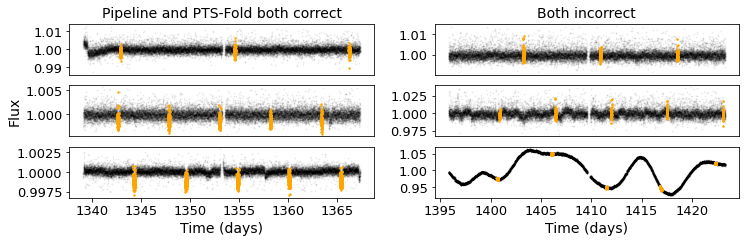

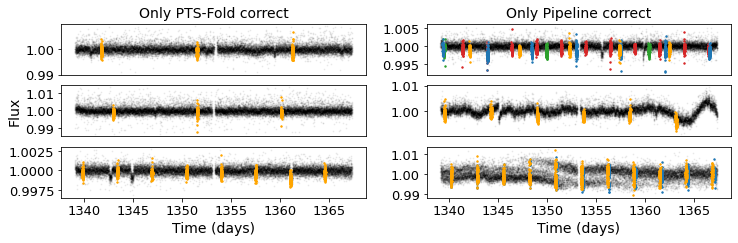

In [206]:
n = 3 
np.random.seed(1)
cs = [plt.plot([])[0].get_color() for i in range(5)]
cs = ["orange"] + [cs[0]] + cs[2:]
plt.close()


fns = {"upper left": lambda i: i*2+1,
       "lower left": lambda i: i*2+1+n*2, 
       "upper right": lambda i: i*2+2, 
       "lower right": lambda i: i*2+2+n*2}
snames = ["AandB", "notAnotB", "AnotB", "BnotA"]
titles = ["Pipeline and PTS-Fold both correct",
          "Both incorrect", "Only PTS-Fold correct",
          "Only Pipeline correct"]
locs = ["upper left", "upper right", "lower left", "lower right"]

for fg in [(0,2),(2,4)]:
    plt.figure(figsize=(12,1.1*n*2))
    for si, (sname, loc) in enumerate(zip(snames[fg[0]:fg[1]], locs[fg[0]:fg[1]])):   
        s_ids = np.random.choice(Arnn_Bppl[sname], replace=False, size=n)
        for i, s_id in enumerate(s_ids):
            plt.subplot(n*2, 2, fns[loc](i))
            plt.title(titles[fg[0]:fg[1]][si], fontsize=14) if i == 0 else None
            b = get_lc(s_id, meta)
            plt.ylabel("Flux", fontsize=14) if i==1 and si==0 else None
            
            masks = b["masks"]
            m = np.any(masks, 0)
            vis.plot(b["time"][~m], b["flux"][~m], a=0.05)
            
            for mi, msk in enumerate(masks):
                vis.plot(b["time"][msk], b["flux"][msk], c=cs[mi], s=2, z=200-mi)
            plt.yticks(fontsize=13)
            plt.xticks([]) if i!=n-1 else plt.xticks(fontsize=13)
            plt.xlabel("Time (days)", fontsize=14)  if i==n-1 else None

In [216]:
s_id = np.random.choice(np.unique(["-".join(s_id.split("-")[:-1]) for s_id in Appl_Bbls["AandB"]]))
s_id = np.random.choice(Appl_Bbls["AandB"])
sampleid = "-".join(s_id.split("-")[:-1])

In [217]:
b = get_lc(s_id, meta)

Text(0.5, 1.0, 'P = 6.54,  t0 = 1002.45')

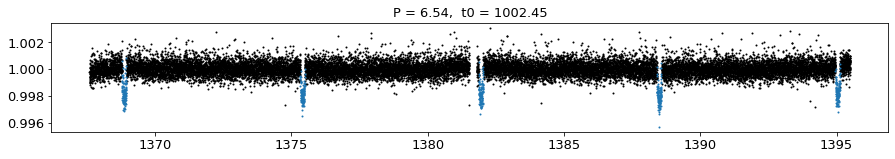

In [218]:
# vis.plot(b)
cs = [plt.plot([])[0].get_color() for i in range(10)]
plt.close()

time, flux = b["time"], b["flux"]
masks = b["masks"]
params = b["meta"]
tr = np.any(masks,0)

plt.figure(figsize=(15,2))
vis.plot(time[~tr], flux[~tr])
for i,m in enumerate(masks):
    vis.plot(time[m], flux[m], c=cs[i])
title=""
for pl_i in params:
    title += f'P = {round(params[pl_i]["orb_period"],2)},  t0 = {round(params[pl_i]["t0"],2)}\n'
plt.title(title[:-1], fontsize=13)

In [219]:
rnn_detections[sampleid]

{'rnn_alg1': {2.220597417179825: {'period': 6.533333333333333,
   't0': 1.2930555555555556,
   'duration': 0.3111111111111118},
  0.021441867749672383: {'period': 7.866666666666667,
   't0': 4.311111111111111,
   'duration': 0.4333333333333331},
  0.0073176254449471385: {'period': 2.6,
   't0': 0.6694444444444445,
   'duration': 0.4583333333333317}}}

In [220]:
bls_detections[sampleid]

{'bls_12h': {12.257846024487582: {'period': 6.544333256715863,
   't0': 1368.8621780152848,
   'duration': 0.14583333333333334},
  4.9738610264715595: {'period': 7.542144291483147,
   't0': 1374.4892613486181,
   'duration': 0.041666666666666664},
  6.288761352194122: {'period': 7.06349231705468,
   't0': 1374.4725946819515,
   'duration': 0.041666666666666664}},
 'bls_out_12h': {12.229781631023979: {'period': 6.544333256715863,
   't0': 1368.8621780152848,
   'duration': 0.14583333333333334},
  5.347017283425938: {'period': 6.656155018687313,
   't0': 1372.2142613486183,
   'duration': 0.041666666666666664},
  4.794761519573622: {'period': 6.592789548210602,
   't0': 1373.1663446819516,
   'duration': 0.10416666666666667}}}

In [35]:
prec_lvl = 0.5 # precision_lvl
min_rec = 0.1 # min_recall

rnn_scores, scores_sampleids = get_scores("rnn_alg1", rnn_detections, rnn_results, rnn_thresholds, 
                                         precision_lvl=prec_lvl, min_recall=min_rec, return_sampleids=1)
rnn_scores2 = get_scores("rnn_alg2_10", rnn_detections, rnn_results, rnn_thresholds, 
                                         precision_lvl=prec_lvl, min_recall=min_rec)
bls_scores = get_scores("bls_out_12h", bls_detections, bls_results, bls_thresholds,
                       precision_lvl=prec_lvl, min_recall=min_rec)
pipeline_scores = get_scores("pipeline", pipeline_detections, pipeline_results, pipeline_thresholds,
                            precision_lvl=prec_lvl, min_recall=min_rec)

# at threshold for for which recall>0.1 and precision closest to 0.9
rnn_thresh, rnn_prec, rnn_rec = get_threshold(rnn_results["rnn_alg1"], rnn_thresholds,
                                              precision_lvl=prec_lvl, min_recall=min_rec)
rnn_thresh2, rnn_prec2, rnn_rec2 = get_threshold(rnn_results["rnn_alg2_10"], rnn_thresholds,
                                              precision_lvl=prec_lvl, min_recall=min_rec)
bls_thresh, bls_prec, bls_rec = get_threshold(bls_results["bls_out_12h"], bls_thresholds,
                                             precision_lvl=prec_lvl, min_recall=min_rec)
ppl_thresh, ppl_prec, ppl_rec = get_threshold(pipeline_results["pipeline"], pipeline_thresholds,
                                              precision_lvl=prec_lvl, min_recall=min_rec)

Arnn_Bbls = A_vs_B(rnn_scores, bls_scores, scores_sampleids)
Abls_Bppl = A_vs_B(bls_scores, pipeline_scores,  scores_sampleids)
Arnn_Bppl = A_vs_B(rnn_scores, pipeline_scores, scores_sampleids)

In [36]:
# # pick specific example
# # s_id = np.random.choice(Arnn_Bbls["BnotA"])
# multipl = False
# ntry = 0
# while not multipl:
#     s_id = np.random.choice(Arnn_Bbls["AnotB"])
#     print(s_id)
#     if len(meta[s_id[:-2]]) > 1:
#         multipl = True
#     ntry+=1
#     if ntry>20 and not multipl:
#         print("poopy butthole")
#         break


# get light curve
b = get_lc(s_id, meta)
time, flux, ms, params = b["time"], b["flux"], b["masks"], b["meta"]
mcol, mrow = b["mcol"], b["mrow"]
sigma = params[list(params.keys())[0]]["sigma"]
m = np.any(ms, 0)

flat_ = flatten(time, flux, method='savgol', cval=2, window_length=2881, break_tolerance=0.5)

flux_mean, flux_std = -0.00855536207264449, 4.476568160496235
mcol_mean, mrow_mean = [0.004235565409773808, -0.012309471516072205]
mcol_std, mrow_std = [14.594088007594333, 19.764830985519954]

pp_out = pp.preprocess(flat_.reshape(1,-1), scaling=np.array([sigma]), mode=1, nanmode=2, mean=flux_mean, std=flux_std,
               scale_median=False, center_zero=True, standardize=True,
               centr=[mcol.reshape(1,-1), mrow.reshape(1,-1)], centr_mean=[mcol_mean, mrow_mean], centr_std=[mcol_std, mrow_std],
               window=utils.min2day(60))
flat_, (mean, std), (centr_, centr_mean, centr_std) = pp_out

# get pts
rnn = torch.load("models_all/lilith1500lrd_bigru1centr_m1_n2_w3sqrt/model_0.pt")
flux_in = np.stack((flat_, centr_[0], centr_[1]), -1)
pts = rnn_det.get_pts(rnn, flux_in, additional=False)

# get bls steps
flat = flatten(time[~np.isnan(time)], flux[~np.isnan(time)], method="median", window_length=utils.hour2day(12))
det_bls, steps_bls = bls_det.algorithm(time[~np.isnan(time)], flat, num_iters=3, return_steps=True)

3-382028425-1


In [37]:
det_fold, steps_fold = rnn_det.algorithm1(pts.copy(), num_iters=3, min_transits=3, p_min=2, p_max=None, 
                           step_mult=2, smooth=True, peak_frac=2, show_steps=False, sde=False, return_steps=True)
det_peak, steps_peak = rnn_det.algorithm2(pts.copy(), None, num_iters=3, smooth=True, p_min=2, 
                                 peak_thresh=0.25, return_steps=True)

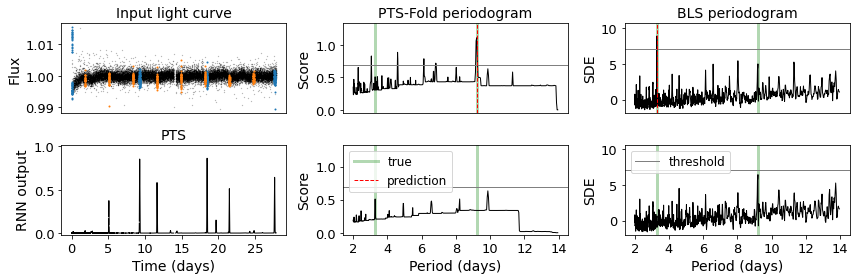

In [41]:
per_lst =[meta[s_id[:-2]][pl_i]["orb_period"] for pl_i in meta[s_id[:-2]]]
t0_lst  =[meta[s_id[:-2]][pl_i]["t0"] for pl_i in meta[s_id[:-2]]]

plt.figure(figsize=(12,4))
plt.subplot(2,3,1)
plt.title("Input light curve", fontsize=14)
vis.plot(time[~m], flux[~m], a=0.5, s=0.05)
for msk in ms: 
    plt.scatter(time[msk], flux[msk], s=1, zorder=200)
#     vis.plot(time[msk], flux[msk], s=1, z=200)
plt.ylabel("Flux", fontsize=14)
plt.xticks([])

plt.subplot(2,3,4)
plt.title("PTS", fontsize=14)
vis.plot(time-np.nanmin(time), steps_fold["pts"][0].squeeze(), scatter=0)
plt.xlabel("Time (days)", fontsize=14)
plt.ylabel("RNN output", fontsize=14)
plt.ylim(-0.02,1.02)

ymax = 1.2 * max(np.max(steps_fold["scores"][0]), rnn_thresh)
for i in range(2):
    plt.subplot(2,3,2+i*3)
    plt.title("PTS-Fold periodogram",fontsize=14) if i==0 else None
    plt.xticks([]) if i==0 else None
    vis.plot(steps_fold["periods"], steps_fold["scores"][i], scatter=0)
    plt.ylim(None, ymax)
    plt.axhline(rnn_thresh, linestyle="-", color="gray", alpha=1, linewidth=1)
    for pi, per in enumerate(per_lst):
        plt.axvline(per, alpha=0.3, zorder=0, color="green", linewidth=3, label="true" if pi==0 else None)
    if np.max(steps_fold["scores"][i])>=rnn_thresh:
        pred = steps_fold["periods"][np.argmax(steps_fold["scores"][i])] 
        plt.axvline(pred, linestyle="--", zorder=20, color="red", linewidth=1)
    plt.plot([], linestyle="--", zorder=20, color="red", linewidth=1, label="prediction")
    plt.ylabel("Score", fontsize=14)
# plt.legend(fontsize=12, bbox_to_anchor=(0.1,1))
plt.legend(fontsize=12)
plt.xlabel("Period (days)", fontsize=14)

    
ymax = 1.2 * max(np.max(steps_bls["sde"][0]), bls_thresh)
for i in range(2):
    plt.subplot(2,3,3+i*3)
    plt.title("BLS periodogram",fontsize=14) if i==0 else None
    plt.xticks([]) if i==0 else None
    vis.plot(steps_bls["periods"][i], steps_bls["sde"][i], scatter=0)
    plt.ylim(None, ymax)
    plt.axhline(bls_thresh, linestyle="-", color="gray", alpha=1, linewidth=1, label="threshold")
    for per in per_lst:
        plt.axvline(per, alpha=0.3, zorder=0, color="green", linewidth=3)
    if np.max(steps_bls["sde"][i])>=bls_thresh:
        pred = steps_bls["periods"][i][np.argmax(steps_bls["sde"][i])]
        plt.axvline(pred, linestyle="--", zorder=20, color="red", linewidth=1)
    plt.ylabel("SDE", fontsize=14)
plt.legend(fontsize=12, loc="upper left")
plt.xlabel("Period (days)", fontsize=14)

plt.tight_layout()
plt.savefig("figures/sf_multi_vice.pdf")

In [88]:
import dataloading

In [327]:
# pick specific example
# s_id = np.random.choice(Arnn_Bbls["BnotA"])


ntry2=0
success=False
while not success:
    
    ntry = 0
    multipl = False
    while not multipl:
        s_id = np.random.choice(scores_sampleids[rnn_scores2==0])
        print(s_id)
        if len(meta[s_id[:-2]]) > 1:
            multipl = True
        ntry+=1
        if ntry>20 and not multipl:
            print("poopy butthole")
            break

    # get light curve
    b = get_lc(s_id, meta)
    time, flux, ms, params = b["time"], b["flux"], b["masks"], b["meta"]
    mcol, mrow = b["mcol"], b["mrow"]
    sigma = params[list(params.keys())[0]]["sigma"]
    m = np.any(ms, 0)

    flat_ = flatten(time, flux, method='savgol', cval=2, window_length=2881, break_tolerance=0.5)

    flux_mean, flux_std = -0.00855536207264449, 4.476568160496235
    mcol_mean, mrow_mean = [0.004235565409773808, -0.012309471516072205]
    mcol_std, mrow_std = [14.594088007594333, 19.764830985519954]

    pp_out = pp.preprocess(flat_.reshape(1,-1), scaling=np.array([sigma]), mode=1, nanmode=2, mean=flux_mean, std=flux_std,
                   scale_median=False, center_zero=True, standardize=True,
                   centr=[mcol.reshape(1,-1), mrow.reshape(1,-1)], centr_mean=[mcol_mean, mrow_mean], centr_std=[mcol_std, mrow_std],
                   window=utils.min2day(60))
    flat_, (mean, std), (centr_, centr_mean, centr_std) = pp_out

    # get pts
    rnn = torch.load("models_all/lilith1500lrd_bigru1centr_m1_n2_w3sqrt/model_0.pt")
    flux_in = np.stack((flat_, centr_[0], centr_[1]), -1)
    pts = rnn_det.get_pts(rnn, flux_in, additional=False)
    
    det_peak, steps_peak = rnn_det.algorithm2(pts.copy(), None, num_iters=3, smooth=True, p_min=2, 
                                 peak_thresh=0.25, return_steps=True)
    
    if len(steps_peak["pts"])>1:
        success = True
    ntry+=1
    if ntry > 20 and not success:
        print("poopy butthole")
        break

1-419667736-4


In [328]:
# det_fold, steps_fold = rnn_det.algorithm1(pts.copy(), num_iters=3, min_transits=3, p_min=2, p_max=None, 
#                            step_mult=2, smooth=True, peak_frac=2, show_steps=False, sde=False, return_steps=True)
cs = [plt.plot([])[0].get_color() for i in range(3)]
plt.close()

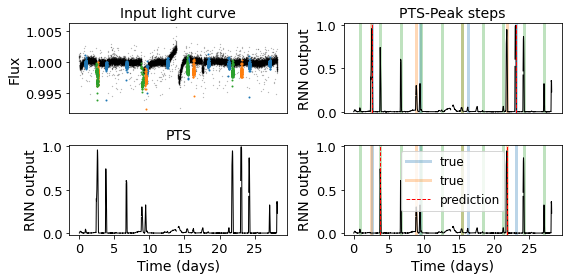

In [329]:
per_lst =[meta[s_id[:-2]][pl_i]["orb_period"] for pl_i in meta[s_id[:-2]]]
t0_lst  =[fix_t0(meta[s_id[:-2]][pl_i]["t0"], meta[s_id[:-2]][pl_i]["orb_period"],
                 int(s_id[0])) for pl_i in meta[s_id[:-2]]]
plt.figure(figsize=(12/3*2,4))
plt.subplot(2,2,1)
plt.title("Input light curve", fontsize=14)
vis.plot(time[~m], flux[~m], a=0.5, s=0.05)
for msk in ms: 
    plt.scatter(time[msk], flux[msk], s=1, zorder=200)
#     vis.plot(time[msk], flux[msk], s=1, z=200)
plt.ylabel("Flux", fontsize=14)
plt.xticks([])

plt.subplot(2,2,3)
plt.title("PTS", fontsize=14)
vis.plot(time - np.nanmin(time), steps_peak["pts"][0].squeeze(), scatter=0)
plt.xlabel("Time (days)", fontsize=14)
plt.ylabel("RNN output", fontsize=14)
plt.ylim(-0.02,1.02)

# ymax = 1.2 * max(np.max(steps_peak["scores"][0]), rnn_thresh2)
for i in range(2):
    plt.subplot(2,2,2+i*2)
    plt.title("PTS-Peak steps",fontsize=14) if i==0 else None
    plt.xticks([]) if i==0 else None
    vis.plot(time- np.nanmin(time), steps_peak["pts"][i], scatter=0)
    plt.ylim(-0.02,1.02)
#     plt.axhline(rnn_thresh2, linestyle="-", color="gray", alpha=1, linewidth=1)
    for j in range(len(per_lst)):
        tt = t0_lst[j] - np.nanmin(time)
        while tt < np.nanmax(time)- np.nanmin(time):
            plt.axvline(tt, alpha=0.3, zorder=0, linewidth=3, color=cs[j])
            tt += per_lst[j]
    plt.plot([], alpha=0.3, linewidth=3, color=cs[0], label="true")
    plt.plot([], alpha=0.3, linewidth=3, color=cs[1], label="true")
    scores = list(det_peak.keys())
    if len(scores) >= i+1:
        if scores[i] > rnn_thresh2:
            tt = det_peak[scores[i]]["t0"]
            while tt < np.nanmax(time)- np.nanmin(time):
#                 print(tt)
                plt.axvline(tt, linestyle="--", zorder=20, color="red", linewidth=1)
                tt += det_peak[scores[i]]["period"]
    plt.plot([], linestyle="--", color="red", linewidth=1, label="prediction")
    plt.ylabel("RNN output", fontsize=14)
# plt.legend(fontsize=12, bbox_to_anchor=(0.1,1))
plt.legend(fontsize=12)
plt.xlabel("Time (days)", fontsize=14)

plt.tight_layout()
# plt.savefig("figures/sf_multi_not_peak_2.pdf")

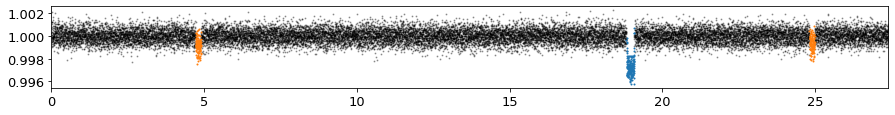

In [30]:
st_params = lcsim.get_stellar_params(rot_sigma=1e-15, rot_period=30, gran_period=30, gran_sigma=1e-15)
# st_params=None

# pick one! (good and bad examples)
i = [4664-1,5057-1,5169-1][0]   # & min period 20 & success = sum(n_tr)==3 & min rdepth=.5)

success=False
while not success:
    i += 1
    np.random.seed(i)
    lc = lcsim.get_lightcurve(num_planets=2, min_transits=1, period_range=(20,100), t_max=27.4, 
                      max_attempts=4, max_snr_attempts=10, snr_range=(3,80), sigma=None,
                      rdepth_range=(1,10.), dur_range=(0,utils.hour2day(14)), st_params=st_params)
    time, flux, pl_masks, params = lc
    n_tr = [params["planets"][pl_i]["pl_transits"] for pl_i in [0,1]]
    success = sum(n_tr)==3

pl1, pl2 = pl_masks[0], pl_masks[1]
nontr = ~np.any(pl_masks, 0)

plt.figure(figsize=(15,1.5))
vis.plot(time[nontr], flux[nontr], c="black", a=0.3)
for msk in pl_masks:
    vis.plot(time[msk], flux[msk], c=plt.plot([])[0].get_color(), a=1)
plt.xlim(0,time[-1])
plt.show()

In [31]:
rnn_repr2 = torch.load("models/bigru1repr2_sim.pt")
flux_ = (flux-1) / params["sigma"]
flux_ = (flux_ - (-0.02693141794739591))/2.1573894104562314
pts, reprs = rnn_det.get_pts(rnn_repr2, flux_.reshape(1,-1), additional=True)
det_peak, steps_peak = rnn_det.algorithm2(pts, [], num_iters=2, smooth=True, return_steps=1, peak_thresh=0.5)

In [32]:
cs = [plt.plot([])[0].get_color() for j in range(10)]
plt.close()
plt.figure(figsize=(1.2,1.2))

plt.show()

<Figure size 86.4x86.4 with 0 Axes>

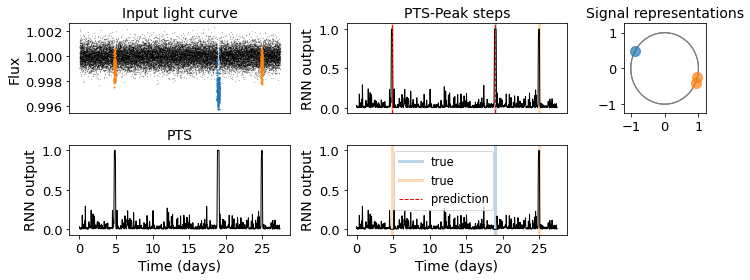

In [37]:
per_lst = [params["planets"][pl_i]["pl_period"] for pl_i in params["planets"]]
t0_lst = [params["planets"][pl_i]["pl_t0"] for pl_i in params["planets"]]

fig = plt.figure(figsize=(12/6*5,4))
gs = fig.add_gridspec(2,5)

fig.add_subplot(gs[0, 0:2])
plt.title("Input light curve", fontsize=14)
vis.plot(time[nontr], flux[nontr], a=0.5, s=0.05)
for msk in pl_masks: 
    plt.scatter(time[msk], flux[msk], s=1, zorder=200)
#     vis.plot(time[msk], flux[msk], s=1, z=200)
plt.ylabel("Flux", fontsize=14)
plt.xticks([])

fig.add_subplot(gs[1, 0:2])
plt.title("PTS", fontsize=14)
vis.plot(time - np.nanmin(time), steps_peak["pts"][0].squeeze(), scatter=0)
plt.xlabel("Time (days)", fontsize=14)
plt.ylabel("RNN output", fontsize=14)
plt.ylim(-0.07,1.07)


for i in range(2):
    fig.add_subplot(gs[i, 2:4])
    
    plt.title("PTS-Peak steps",fontsize=14) if i==0 else None
    plt.xticks([]) if i==0 else None
    vis.plot(time- np.nanmin(time), steps_peak["pts"][i], scatter=0)
    plt.ylim(-0.07,1.07)
#     plt.axhline(rnn_thresh2, linestyle="-", color="gray", alpha=1, linewidth=1)
    for j in range(len(per_lst)):
        tt = t0_lst[j] - np.nanmin(time)
        while tt < np.nanmax(time)- np.nanmin(time):
            plt.axvline(tt, alpha=0.3, zorder=0, linewidth=3, color=cs[j])
            tt += per_lst[j]
    plt.plot([], alpha=0.3, linewidth=3, color=cs[0], label="true")
    plt.plot([], alpha=0.3, linewidth=3, color=cs[1], label="true")
    scores = list(det_peak.keys())
    if len(scores) >= i+1:
        if scores[i] > 1:
            tt = det_peak[scores[i]]["t0"]
            while tt < np.nanmax(time)- np.nanmin(time):
#                 print(tt)
                plt.axvline(tt, linestyle="--", zorder=20, color="red", linewidth=1)
                tt += det_peak[scores[i]]["period"]
    plt.plot([], linestyle="--", color="red", linewidth=1, label="prediction")
    plt.ylabel("RNN output", fontsize=14)
plt.legend(fontsize=11.5, bbox_to_anchor=(0.19,1), loc="upper left")
# plt.legend(fontsize=12)
plt.xlabel("Time (days)", fontsize=14)


fig.add_subplot(gs[0, 4])
for pi, peak in enumerate(steps_peak["peaks"]):

    c = cs[np.argmax([pl1[peak].sum(), pl2[peak].sum()])]
    if sum([pl1[peak].sum(), pl2[peak].sum()]) == 0:
        c = "lightgray"
    
    reprs_mean = reprs[peak].mean(0)
    reprs_mnorm = np.linalg.norm(reprs_mean)
    plt.scatter(reprs_mean[0]/reprs_mnorm, reprs_mean[1]/reprs_mnorm, color=c, s=100, zorder=10, alpha=0.7)

    theta = np.linspace(0, 2*np.pi, 100)
    x1, x2 = np.cos(theta), np.sin(theta)
    plt.plot(x1, x2, color="gray", linewidth=1)
    r = 1.2
    plt.xlim(-r*1.01,r*1.01), plt.ylim(-r*1.05,r*1.05)
    plt.xticks([-1,0,1], fontsize=13), plt.yticks([-1,0,1], fontsize=13)
#     plt.xlabel("$x_1$", fontsize=14), plt.ylabel("\n\n\n\n\n$x_2$", fontsize=14)
    plt.title("Signal representations", fontsize=14)

plt.tight_layout()
plt.savefig("figures/sf_multi_peak_repr_3.pdf", bbox_inches="tight")